## Bribes research
First, calculating different metrics, such as bribe dilutions and $I/O

In [1]:
import math

import pandas as pd
import requests
from IPython.core.display_functions import display

from notebooks.bribes_research.constants import BADGER_LOW_BOUND
from notebooks.bribes_research.constants import BADGER_UPPER_BOUND
from notebooks.bribes_research.constants import BRIBES_URL
from notebooks.bribes_research.constants import DASHBOARD_URL
from notebooks.bribes_research.constants import FEE
from notebooks.bribes_research.constants import POOL_WEIGHTS
from notebooks.bribes_research.constants import PROTOCOL_AURA
from notebooks.bribes_research.constants import PROTOCOL_CVX
from notebooks.bribes_research.constants import REBALANCING_STEP
from notebooks.bribes_research.constants import STEP
from notebooks.bribes_research.constants import TABLE_COLUMNS_COMMON_METRICS
from notebooks.bribes_research.helpers import calculate_metrics
from notebooks.bribes_research.helpers import fetch_token_prices

pd.set_option('display.max_rows', 500)


table_rows = []
average_weighed_metrics = []
cvx_io_metrics = []
aura_io_metrics = []
total_bribes_table = []
badger_price = fetch_token_prices(['badger-dao'])['badger-dao']['usd']

cvx_bribes = requests.post(BRIBES_URL, json={'platform': "votium", 'protocol': "cvx-crv"}).json()
cvx_dash = requests.post(DASHBOARD_URL, json={"id": "bribes-overview-votium"}).json()
aura_bribes = requests.post(BRIBES_URL, json={'platform': "hh", 'protocol': "aura-bal"}).json()
aura_dash = requests.post(DASHBOARD_URL, json={"id": "bribes-overview-aura"}).json()
total_bribes_cvx = sum([bribe['amountDollars'] for bribe in cvx_bribes['epoch']['bribes']])
dollar_spent_on_bribes_cvx = cvx_dash['dashboard']['rewardPerDollarBribe']

total_bribes_aura = sum([bribe['amountDollars'] for bribe in aura_bribes['epoch']['bribes']])
dollar_spent_on_bribes_aura = aura_dash['dashboard']['rewardPerDollarBribe']


for bribe in range(BADGER_LOW_BOUND, BADGER_UPPER_BOUND, STEP):
    badger_bribe_in_dollar = bribe * badger_price
    fees = badger_bribe_in_dollar * FEE
    badger_bribe_in_dollar_after_fees = badger_bribe_in_dollar - fees
    cvx_dilution_50, cvx_in_out_50 = calculate_metrics(badger_bribe_in_dollar_after_fees / 2, total_bribes_cvx,
                                                       dollar_spent_on_bribes_cvx)
    aura_dilution_50, aura_in_out_50 = calculate_metrics(badger_bribe_in_dollar_after_fees / 2, total_bribes_aura,
                                                         dollar_spent_on_bribes_aura)
    # Rebalance here
    cvx_in_out_floating = cvx_in_out_50
    aura_in_out_floating = aura_in_out_50

    cvx_bribe_portion = aura_bribe_portion = badger_bribe_in_dollar_after_fees / 2
    cvx_dilution = None
    aura_dilution = None
    while not math.isclose(cvx_in_out_floating, aura_in_out_floating, abs_tol=0.5):
        # Do not allow negative numbers
        cvx_bribe_portion_percent = round(cvx_bribe_portion / badger_bribe_in_dollar_after_fees * 100, 2)
        aura_bribe_portion_percent = round(aura_bribe_portion / badger_bribe_in_dollar_after_fees * 100, 2)
        # If any of bribe percent is getting closer to 0, break the loop to not go to negative numbers
        if math.isclose(cvx_bribe_portion_percent, 0, abs_tol=0.1) or math.isclose(aura_bribe_portion_percent, 0, abs_tol=0.1):
            break
        if cvx_in_out_floating > aura_in_out_floating:
            # Take bribe portion from aura and give it to cvx
            bribe_stolen = aura_bribe_portion * REBALANCING_STEP
            aura_bribe_portion -= bribe_stolen
            cvx_bribe_portion += bribe_stolen
        elif aura_in_out_floating > cvx_in_out_floating:
            # Take bribe portion from cvx and give it to aura
            bribe_stolen = aura_bribe_portion * REBALANCING_STEP
            cvx_bribe_portion -= bribe_stolen
            aura_bribe_portion += bribe_stolen
        if cvx_bribe_portion <= 0 or aura_bribe_portion <= 0:
            break
        cvx_dilution, cvx_in_out_floating = calculate_metrics(cvx_bribe_portion, total_bribes_cvx,
                                                              dollar_spent_on_bribes_cvx)
        aura_dilution, aura_in_out_floating = calculate_metrics(aura_bribe_portion, total_bribes_aura,
                                                                dollar_spent_on_bribes_aura)
    cvx_percent = round(cvx_bribe_portion / badger_bribe_in_dollar_after_fees * 100, 2)
    aura_percent = round(aura_bribe_portion / badger_bribe_in_dollar_after_fees * 100, 2)

    cvx_in_out_floating_weights = [weight * cvx_in_out_floating for weight in POOL_WEIGHTS]
    aura_in_out_floating_weights = [weight * aura_in_out_floating for weight in POOL_WEIGHTS]

    table_rows.append(
        [PROTOCOL_CVX, bribe, badger_bribe_in_dollar_after_fees, fees, cvx_percent,
         cvx_bribe_portion, cvx_dilution, *cvx_in_out_floating_weights]
    )
    table_rows.append(
        [PROTOCOL_AURA, bribe, badger_bribe_in_dollar_after_fees, fees, aura_percent,
         aura_bribe_portion, aura_dilution, *aura_in_out_floating_weights]
    )
    # Pack Average weighed values into another table
    dollar_io_average_metric = ((cvx_percent / 100) * (cvx_in_out_floating / 100)) + ((aura_percent / 100) * (aura_in_out_floating / 100))
    average_weighed_metrics.append(dollar_io_average_metric)
    cvx_io_metrics.append(cvx_in_out_floating / 100)
    aura_io_metrics.append(aura_in_out_floating / 100)
    total_bribes_table.append(badger_bribe_in_dollar_after_fees)

## $I/O Results

In [2]:
dataframe = pd.DataFrame(data=table_rows, columns=TABLE_COLUMNS_COMMON_METRICS)
display(dataframe)

,Market,BADGER bribe,Total bribe in $,Fees,Bribes Portion %,Bribes Portion,Dilution,$I/O 50%,$I/O 60%,$I/O 80%,$I/O 100%
0,CVX,2000,7660.8,319.2,0.10,7.967997,0.000273,71.890568,86.268682,115.024909,143.781136
1,AURA,2000,7660.8,319.2,99.90,7652.832003,2.121409,99.090152,118.908183,158.544243,198.180304
2,CVX,4000,15321.6,638.4,0.10,15.935993,0.000546,71.890372,86.268446,115.024595,143.780744
3,AURA,4000,15321.6,638.4,99.90,15305.664007,4.242819,96.942484,116.330980,155.107974,193.884967
4,CVX,6000,22982.4,957.6,0.10,23.903990,0.000818,71.890176,86.268211,115.024281,143.780352
5,AURA,6000,22982.4,957.6,99.90,22958.496010,6.364228,94.794815,113.753778,151.671704,189.589630
6,CVX,8000,30643.2,1276.8,0.10,31.871986,0.001091,71.889980,86.267976,115.023968,143.779960
7,AURA,8000,30643.2,1276.8,99.90,30611.328014,8.485637,92.647147,111.176576,148.235434,185.294293
8,CVX,10000,38304.0,1596.0,0.10,39.839983,0.001364,71.889784,86.267740,115.023654,143.779567
9,AURA,10000,38304.0,1596.0,99.90,38264.160017,10.607046,90.499478,108.599374,144.799165,180.998956


## Displaying $I/O metric for latest bribes round on both Votium and HH combined

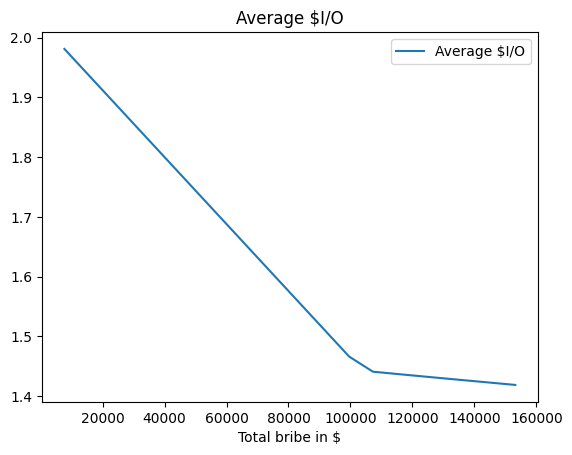

In [3]:
df = pd.DataFrame({
    'Total bribe in $': total_bribes_table,
   'Average $I/O': average_weighed_metrics,
   })
lines = df.plot.line(x="Total bribe in $", y='Average $I/O', title="Average $I/O")

## Displaying $I/O metric for latest bribes round on both Votium and HH separately

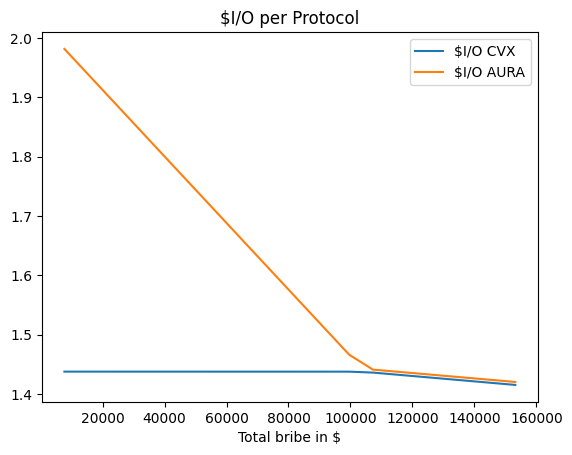

In [4]:
df = pd.DataFrame({
    'Total bribe in $': total_bribes_table,
   '$I/O CVX': cvx_io_metrics,
   '$I/O AURA': aura_io_metrics,
   })
lines_breakdown = df.plot.line(x="Total bribe in $", title="$I/O per Protocol")